<h1>Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines</h1>

## Imports

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [76]:
train = pd.read_csv('./training_set_features.csv', index_col='respondent_id')

In [77]:
test = pd.read_csv('./test_set_features.csv', index_col='respondent_id')

In [78]:
labels = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')

### Imputation strategy

In [79]:
num_cols = train.select_dtypes('number').columns

In [80]:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [81]:
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [82]:
assert len(num_cols)+len(cat_cols)+len(ord_cols) == train.shape[1]

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder as oe
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

In [84]:
# Impute train
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [85]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='missing')

In [86]:
# Impute test
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

In [87]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='missing')

### Train test split

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_test, y_train, y_test = train_test_split( train, labels, test_size=0.3, random_state=68)

## Step Forward Selection


In [90]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [91]:
# Get the index number of categorical features
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

<ipython-input-91-0818a4dee0f1>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_train.dtypes != np.float)[0]


In [92]:
cat_cols = X_train.select_dtypes('object').columns

In [93]:
ct = ColumnTransformer(
    [('ordinal', oe(), cat_cols)],
    remainder='passthrough')

In [101]:
all_cols = X_train.columns

### Feature selection using CatBoost for H1N1

In [94]:
sfs2 = SFS(AdaBoostClassifier(n_estimators=50, learning_rate=1.0), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [95]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   29.2s finished

[2021-12-01 16:42:49] Features: 1/35 -- score: 0.7071737862072726[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   30.2s finished

[2021-12-01 16:43:19] Features: 2/35 -- score: 0.7862018627174202[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   30.3s finished

[2021-12-01 16:43:49] Features: 3/35 -- score: 0.8228834072114403[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [96]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[0.7050372019814923, 0.708107924020672, 0.7061...",0.707174,"(28,)",0.005078,0.003951,0.001975
2,"(21, 28)","[0.7903103133556435, 0.7825310975454012, 0.784...",0.786202,"(21, 28)",0.008076,0.006283,0.003142
3,"(21, 26, 28)","[0.8302676105428481, 0.8225988267647484, 0.811...",0.822883,"(21, 26, 28)",0.00977,0.007602,0.003801
4,"(21, 26, 27, 28)","[0.846927758021371, 0.8426487616323126, 0.8341...",0.843052,"(21, 26, 27, 28)",0.008633,0.006717,0.003359
5,"(21, 25, 26, 27, 28)","[0.8521345867218197, 0.8458855882778643, 0.840...",0.848876,"(21, 25, 26, 27, 28)",0.008562,0.006661,0.003331
6,"(21, 25, 26, 27, 28, 31)","[0.8541702351765166, 0.8481215890611563, 0.841...",0.851046,"(21, 25, 26, 27, 28, 31)",0.009472,0.00737,0.003685
7,"(1, 21, 25, 26, 27, 28, 31)","[0.8559645032336025, 0.8498056669476302, 0.843...",0.85256,"(1, 21, 25, 26, 27, 28, 31)",0.009544,0.007426,0.003713
8,"(1, 10, 21, 25, 26, 27, 28, 31)","[0.8577483320678438, 0.8508088341719666, 0.845...",0.854238,"(1, 10, 21, 25, 26, 27, 28, 31)",0.010004,0.007783,0.003892
9,"(1, 10, 21, 22, 25, 26, 27, 28, 31)","[0.8587681802261519, 0.853495866431679, 0.8456...",0.855536,"(1, 10, 21, 22, 25, 26, 27, 28, 31)",0.010545,0.008204,0.004102
10,"(1, 10, 21, 22, 25, 26, 27, 28, 31, 32)","[0.8596043832805408, 0.8536220871327255, 0.847...",0.85691,"(1, 10, 21, 22, 25, 26, 27, 28, 31, 32)",0.010028,0.007802,0.003901


In [97]:
print(sfdf2.loc[19, 'feature_idx'])

(0, 1, 3, 6, 7, 10, 13, 14, 19, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32)


In [108]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [102]:
selected_columns2 = [all_cols[i] for i in 
                     list((0, 3, 5, 6, 10, 12, 13, 14, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32))]

In [103]:
selected_columns2

['h1n1_concern',
 'behavioral_avoidance',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

### Feature selection using CatBoost for seasonal flu

In [106]:
sfs3 = SFS(AdaBoostClassifier(n_estimators=50, learning_rate=1.0), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [107]:
sfs3 = sfs3.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   29.7s finished

[2021-12-01 17:03:16] Features: 1/35 -- score: 0.7149885991744259[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   31.0s finished

[2021-12-01 17:03:47] Features: 2/35 -- score: 0.7765335262716625[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   31.9s finished

[2021-12-01 17:04:19] Features: 3/35 -- score: 0.810435052700155[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [ ]:
sfdf3 = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
sfdf3

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(31,)","[0.704703565267395, 0.7271142898217366, 0.7135...",0.714989,"(31,)",0.00943423,0.00734015,0.00367008
2,"(0, 31)","[0.7679320011500862, 0.7837448246118458, 0.778...",0.776608,"(0, 31)",0.00663211,0.00516001,0.00258
3,"(0, 22, 31)","[0.8103923231742383, 0.8125849626221966, 0.808...",0.811318,"(0, 22, 31)",0.00287633,0.00223788,0.00111894
4,"(0, 22, 30, 31)","[0.8374371765382405, 0.835688757906843, 0.8293...",0.83481,"(0, 22, 30, 31)",0.00369949,0.00287833,0.00143916
5,"(0, 10, 22, 30, 31)","[0.8448720529039677, 0.8480760494537091, 0.838...",0.844628,"(0, 10, 22, 30, 31)",0.00400366,0.00311499,0.00155749
6,"(0, 10, 22, 30, 31, 32)","[0.8511431857389303, 0.8532162162162161, 0.846...",0.850169,"(0, 10, 22, 30, 31, 32)",0.00298461,0.00232213,0.00116106
7,"(0, 10, 13, 22, 30, 31, 32)","[0.8519936745255894, 0.8555786371477861, 0.847...",0.852078,"(0, 10, 13, 22, 30, 31, 32)",0.00344723,0.00268206,0.00134103
8,"(0, 10, 13, 22, 26, 30, 31, 32)","[0.8537338987924092, 0.8582610695802186, 0.849...",0.854166,"(0, 10, 13, 22, 26, 30, 31, 32)",0.003782,0.00294252,0.00147126
9,"(0, 10, 13, 22, 26, 29, 30, 31, 32)","[0.85508309373203, 0.8589971247843589, 0.84789...",0.854946,"(0, 10, 13, 22, 26, 29, 30, 31, 32)",0.00481745,0.00374814,0.00187407
10,"(0, 10, 13, 22, 25, 26, 29, 30, 31, 32)","[0.8547544565842438, 0.8601444795859688, 0.848...",0.855745,"(0, 10, 13, 22, 25, 26, 29, 30, 31, 32)",0.00530315,0.00412603,0.00206301


In [ ]:
print(sfdf3.loc[19, 'feature_idx'])

(0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32)


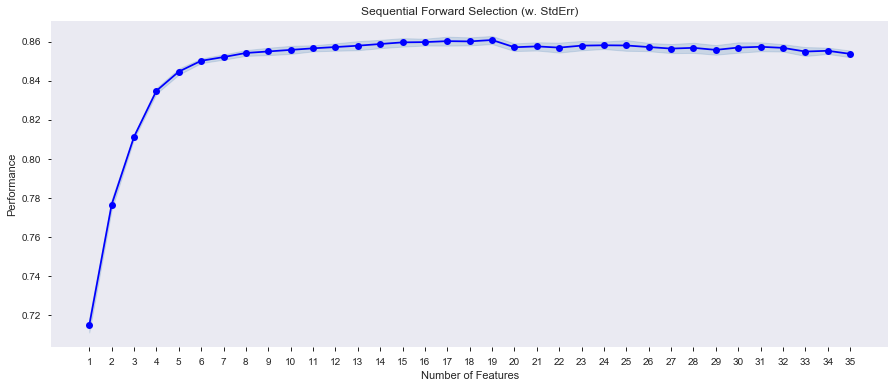

In [ ]:
fig = plot_sfs(sfs3.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
selected_columns3 = [all_cols[i] for i in 
                     list((0, 1, 4, 6, 10, 13, 14, 16, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32))]

In [ ]:
selected_columns3

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_face_mask',
 'behavioral_large_gatherings',
 'doctor_recc_seasonal',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_risk',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [ ]:
selected_columns_h1 = selected_columns2
selected_columns_se = selected_columns3

Essentially there seems to be no advantage to make feature selection for `H1N1` while there might be a small improvment, that must be verified, using only 19 columns for `seasonal flu`

© Andrea Dalseno May 2020